In [10]:
import pickle
import cv2
from tqdm.auto import tqdm
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
from model import VPTEncoder, VPTCNNEncoder, Controller
from memory import SituationLoader, Memory
from matplotlib import pyplot as plt

from openai_vpt.lib.action_mapping import CameraHierarchicalMapping
from openai_vpt.lib.actions import ActionTransformer
from action_utils import ActionProcessor

from openai_vpt.lib.policy import MinecraftPolicy, VPTCNN
from openai_vpt.lib.tree_util import tree_map

In [59]:
in_model = "data/VPT-models/foundation-model-1x.model"
in_weights = "data/VPT-models/foundation-model-1x-net.weights"
cnn_weights = "data/VPT-models/foundation-model-1x-cnn.weights"

In [61]:
vpt = VPTCNNEncoder(in_model, cnn_weights, freeze=True)
vpt.eval()
expert_dataloader = SituationLoader(vpt)

In [62]:
vpt(np.random.randn(640, 360, 3)).squeeze()

tensor([0.1984, 0.6767, 0.5901,  ..., 0.5309, 0.0000, 0.3805], device='cuda:0')

In [63]:
demonstrations = expert_dataloader.load_demonstrations(num_demos=1)

Loading expert demonstrations:   0%|          | 0/1 [00:00<?, ?it/s]

In [64]:
encoded_demos = expert_dataloader.encode_demonstrations(demonstrations)

Encoding expert demonstrations:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding Trajectory:   0%|          | 0/1130 [00:00<?, ?it/s]

In [ ]:
list(map(lambda x: x.tolist(), encoded_demos[0]['encoded_demo']))

In [65]:
situations = expert_dataloader.create_situations(encoded_demos, stride=10, window_size=40)

Creating situations:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
situations = expert_dataloader.load_encoded_demos_to_situations(stride=8)

In [8]:
PINECONE_API_KEY = "2d4c3830-d564-424e-9b7f-1ed18357b257"
PINECONE_ENV = "asia-southeast1-gcp"

In [9]:
import pinecone

pinecone.init(api_key=PINECONE_API_KEY,
              environment=PINECONE_ENV)

In [10]:
pinecone.create_index("example-index", dimension=1024)

In [4]:
import pickle

In [5]:
with open("data/situations.pkl", "wb") as f:
    situations = pickle.load(f)

In [66]:
memory = Memory()

In [67]:
memory.create_index(situations)

In [32]:
memory.save_index(save_dir="data", filename="cnn_memory")

In [ ]:
# if 1 min can encode 4 trajectories, then how many hours can it encode 1000 trajectories?
# 1000 trajectories * 4 min / 60 min = 33.3 hours
# if I use 4 gpus, then it will take 8.3 hours

In [9]:
memory.index.reconstruct(18000)

array([ 2.3652894 , -0.2765258 , -0.38082844, ..., -0.13958964,
       -0.09800015, -0.21801321], dtype=float32)

In [10]:
memory.load_index('data/memory.json')

In [68]:
query = np.array(situations[0]["situation"])

In [44]:
query

array([0.6709915, 0.764151 , 0.4909567, ..., 0.8503056, 1.1980915,
       0.8028726], dtype=float32)

In [69]:
res = memory.search(query, k=5)

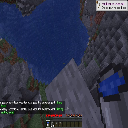

In [70]:
Image.fromarray(demonstrations[0]["video"][res[0]["sit_frame_idx"]][..., ::-1])

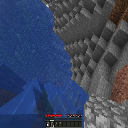

In [71]:
Image.fromarray(demonstrations[0]["video"][res[4]["sit_frame_idx"]][..., ::-1])

In [ ]:
controller = Controller()

In [ ]:
def one_hot_encode(actions: list, num_classes: int, add_batch_dim: bool = True):
    '''One-hot encodes the actions'''
    actions = torch.tensor(actions)
    if add_batch_dim:
        actions = actions.unsqueeze(0)
    return torch.nn.functional.one_hot(actions, num_classes=num_classes).float()

In [ ]:
_observation = torch.Tensor(situations[0]["situation"]).reshape(1, 1, -1)
_situation = torch.Tensor(situations[0]["situation"]).reshape(1, 1, -1)
_actions = situations[10]["actions"]
_actions = {
    "camera": one_hot_encode(_actions['camera'], 121),
    "keyboard": one_hot_encode(_actions['buttons'], 8641)
}

In [ ]:
out_key, out_cam = controller(_observation, _situation, _actions)

In [ ]:
out_key.shape

In [ ]:
out_cam.shape